<a href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Reinforcement Learning

Reinforcement learning (RL) is a subset of machine learning which poses learning problems as interactions between agents and environments. It often assumes agents have no prior knowledge of a world, so they must learn to navigate environments by optimizing a reward function. Within an environment, an agent can take certain actions and receive feedback, in the form of positive or negative rewards, with respect to their decision. As such, an agent's feedback loop is somewhat akin to the idea of "trial and error", or the manner in which a child might learn to distinguish between "good" and "bad" actions.

In practical terms, our RL agent will interact with the environment by taking an action at each timestep, receiving a corresponding reward, and updating its state according to what it has "learned".  

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

While the ultimate goal of reinforcement learning is to teach agents to act in the real, physical world, simulated environments -- like games and simulation engines -- provide a convenient proving ground for developing RL algorithms and agents.

In previous labs, we have explored both supervised (with LSTMs, CNNs) and unsupervised / semi-supervised (with VAEs) learning tasks. Reinforcement learning is fundamentally different, in that we are training a deep learning algorithm to govern the actions of our RL agent, that is trying, within its environment, to find the optimal way to achieve a goal. The goal of training an RL agent is to determine the best next step to take to earn the greatest final payoff or return. In this lab, we focus on building a reinforcement learning algorithm to master two different environments with varying complexity. 

1.   **Cartpole**:   Balance a pole, protruding from a cart, in an upright position by only moving the base left or right. Environment with a low-dimensional observation space.
2.   [**Driving in VISTA**](https://www.mit.edu/~amini/pubs/pdf/learning-in-simulation-vista.pdf): Learn a driving control policy for an autonomous vehicle, end-to-end from raw pixel inputs and entirely in the data-driven simulation environment of VISTA. Environment with a high-dimensional observation space -- learning directly from raw pixels.

Let's get started! First we'll import TensorFlow, the course package, and some dependencies.


In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Installing MIT deep learning package... Done


In [3]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl

Before we dive in, let's take a step back and outline our approach, which is generally applicable to reinforcement learning problems in general:

1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environemnt.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define a reward function**: describes the reward associated with an action or sequence of actions.
4. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.


# Part 1: Cartpole

## 3.1 Define the Cartpole environment and agent

### Environment 

In order to model the environment for the Cartpole task, we'll be using a toolkit developed by OpenAI called [OpenAI Gym](https://gym.openai.com/). It provides several pre-defined environments for training and testing reinforcement learning agents, including those for classic physics control tasks, Atari video games, and robotic simulations. To access the Cartpole environment, we can use `env = gym.make("CartPole-v0")`, which we gained access to when we imported the `gym` package. We can instantiate different [environments](https://gym.openai.com/envs/#classic_control) by passing the enivronment name to the `make` function.

One issue we might experience when developing RL algorithms is that many aspects of the learning process are inherently random: initializing game states, changes in the environment, and the agent's actions. As such, it can be helpful to set a initial "seed" for the environment to ensure some level of reproducibility. Much like you might use `numpy.random.seed`, we can call the comparable function in gym, `seed`, with our defined environment to ensure the environment's random variables are initialized the same each time.

In [4]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v1")
env.seed(1)

[1]

In Cartpole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center of the track. A visual summary of the cartpole environment is depicted below:

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Given this setup for the environment and the objective of the game, we can think about: 1) what observations help define the environment's state; 2) what actions the agent can take. 

First, let's consider the observation space. In this Cartpole environment our observations are:

1. Cart position
2. Cart velocity
3. Pole angle
4. Pole rotation rate

We can confirm the size of the space by querying the environment's observation space:


In [5]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


Second, we consider the action space. At every time step, the agent can move either right or left. Again we can confirm the size of the action space by querying the environment:

In [6]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Cartpole agent

Now that we have instantiated the environment and understood the dimensionality of the observation and action spaces, we are ready to define our agent. In deep reinforcement learning, a deep neural network defines the agent. This network will take as input an observation of the environment and output the probability of taking each of the possible actions. Since Cartpole is defined by a low-dimensional observation space, a simple feed-forward neural network should work well for our agent. We will define this using the `Sequential` API.


In [7]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),
        
        # TODO: Define the last Dense layer, which will provide the network's output.
        # Think about the space the agent needs to act in!
        tf.keras.layers.Dense(units=n_actions, activation=None) # TODO
        # ['''TODO''' Dense layer to output action probabilities]
    ])
    return model

cartpole_model = create_cartpole_model()

Now that we have defined the core network architecture, we will define an *action function* that executes a forward pass through the network, given a set of observations, and samples from the output. This sampling from the output probabilities will be used to select the next action for the agent. We will also add support so that the `choose_action` function can handle either a single observation or a batch of observations.

**Critically, this action function is totally general -- we will use this function for learning control algorithms for Cartpole, but it is applicable to other RL tasks, as well!**

In [8]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model, 
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation(s) which is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observations, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation

    '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation) # TODO
    # logits = model.predict('''TODO''')

    '''TODO: Choose an action from the categorical distribution defined by the log 
       probabilities of each possible action.'''
    action = tf.random.categorical(logits, num_samples=1)
    # action = ['''TODO''']

    action = action.numpy().flatten()

    return action[0] if single else action

## 3.2 Define the agent's memory

Now that we have instantiated the environment and defined the agent network architecture and action function, we are ready to move on to the next step in our RL workflow:
1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environemnt.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.

In reinforcement learning, training occurs alongside the agent's acting in the environment; an *episode* refers to a sequence of actions that ends in some terminal state, such as the pole falling down or the cart crashing. The agent will need to remember all of its observations and actions, such that once an episode ends, it can learn to "reinforce" the good actions and punish the undesirable actions via training. Our first step is to define a simple `Memory` buffer that contains the agent's observations, actions, and received rewards from a given episode. We will also add support to combine a list of `Memory` objects into a single `Memory`. This will be very useful for batching, which will help you accelerate training later on in the lab.

**Once again, note the modularity of this memory buffer -- it can and will be applied to other RL tasks as well!**

In [9]:
### Agent Memory ###

class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        '''TODO: update the list of actions with new action'''
        self.actions.append(new_action) # TODO
        # ['''TODO''']
        '''TODO: update the list of rewards with new reward'''
        self.rewards.append(new_reward) # TODO
        # ['''TODO''']

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

## 3.3 Reward function

We're almost ready to begin the learning algorithm for our agent! The next step is to compute the rewards of our agent as it acts in the environment. Since we (and the agent) is uncertain about if and when the game or task will end (i.e., when the pole will fall), it is useful to emphasize getting rewards **now** rather than later in the future -- this is the idea of discounting. This is a similar concept to discounting money in the case of interest. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest.

To compute the expected cumulative reward, known as the **return**, at a given timestep in a learning episode, we sum the discounted rewards expected at that time step $t$, within a learning episode, and projecting into the future. We define the return (cumulative reward) at a time step $t$, $R_{t}$ as:

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

where  $0 < \gamma < 1$ is the discount factor and $r_{t}$ is the reward at time step $t$, and the index $k$ increments projection into the future within a single learning episode. Intuitively, you can think of this function as depreciating any rewards received at later time steps, which will force the agent prioritize getting rewards now. Since we can't extend episodes to infinity, in practice the computation will be limited to the number of timesteps in an episode -- after that the reward is assumed to be zero.

Take note of the form of this sum -- we'll have to be clever about how we implement this function. Specifically, we'll need to initialize an array of zeros, with length of the number of time steps, and fill it with the real discounted reward values as we loop through the rewards from the episode, which will have been saved in the agents memory. What we ultimately care about is which actions are better relative to other actions taken in that episode -- so, we'll normalize our computed rewards, using the mean and standard deviation of the rewards across the learning episode.

We will use this definition of the reward function in both parts of the lab so make sure you have it executed!


In [10]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
      
    return normalize(discounted_rewards)

## 3.4 Learning algorithm

Now we can start to define the learing algorithm which will be used to reinforce good behaviors of the agent and discourage bad behaviours. In this lab, we will focus on *policy gradient* methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. We achieve this by simply **scaling** the probabilities by their associated rewards -- effectively amplifying the likelihood of actions that resujlt in large rewards.

Since the log function is monotonically increasing, this means that minimizing **negative likelihood** is equivalent to minimizing **negative log-likelihood**.  Recall that we can easily compute the negative log-likelihood of a discrete action by evaluting its [softmax cross entropy](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Like in supervised learning, we can use stochastic gradient descent methods to achieve the desired minimization. 

Let's begin by defining the loss function.

In [11]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
    '''TODO: complete the function call to compute the negative log probabilities'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=actions) # TODO
    # neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
    #    logits='''TODO''', labels='''TODO''')
  
    '''TODO: scale the negative log probability by the rewards'''
    loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
    # loss = tf.reduce_mean('''TODO''')
    return loss

Now let's use the loss function to define a training step of our learning algorithm. This is a very generalizable definition which we will use 

In [12]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else: 
            prediction = model(observations)

        '''TODO: call the compute_loss function to compute the loss'''
        loss = loss_function(prediction, actions, discounted_rewards) # TODO
        # loss = loss_function('''TODO''', '''TODO''', '''TODO''')

    '''TODO: run backpropagation to minimize the loss using the tape.gradient method. 
             Unlike supervised learning, RL is *extremely* noisy, so you will benefit 
             from additionally clipping your gradients to avoid falling into 
             dangerous local minima. After computing your gradients try also clipping
             by a global normalizer. Try different clipping values, usually clipping 
             between 0.5 and 5 provides reasonable results. '''
    grads = tape.gradient(loss, model.trainable_variables) # TODO
    # grads = tape.gradient('''TODO''', '''TODO''')
    grads, _ = tf.clip_by_global_norm(grads, 2)
    # grads, _ = tf.clip_by_global_norm(grads, '''TODO''')
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## 3.5 Run cartpole!

Having had no prior knowledge of the environment, the agent will begin to learn how to balance the pole on the cart based only on the feedback received from the environment! Having defined how our agent can move, how it takes in new observations, and how it updates its state, we'll see how it gradually learns a policy of actions to optimize balancing the pole as long as possible. To do this, we'll track how the rewards evolve as a function of training -- how should the rewards change as training progresses?

In [13]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# TODO: Learning rate and optimizer
learning_rate = 1e-3
# learning_rate = '''TODO'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = '''TODO'''

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

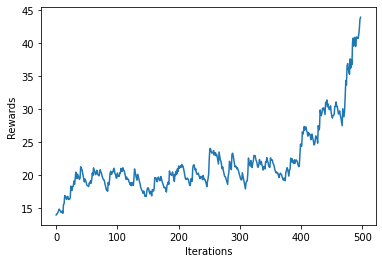

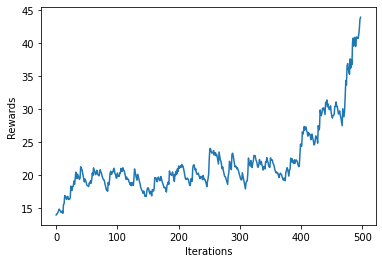

In [14]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as 
#        well (to re-initialize the model and optimizer)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
          
            # initiate training - remember we don't know anything about how the 
            #   agent is doing until it has crashed!
            g = train_step(cartpole_model, compute_loss, optimizer, 
                       observations=np.vstack(memory.observations),
                       actions=np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))
          
            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

To get a sense of how our agent did, we can save a video of the trained model working on balancing the pole. Realize that this is a brand new environment that the agent has not seen before!

Let's display the saved video to watch how our agent did!


In [15]:
matplotlib.use('Agg') 
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v1")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 82 frames into CartPole-v1.mp4!


How does the agent perform? Could you train it for shorter amounts of time and still perform well? Do you think that training longer would help even more? 

# Part 2: Training Autonomous Driving Policies in VISTA
Autonomous control has traditionally be dominated by algorithms that explicitly decompose individual aspects of the control pipeline. For example, in autonomous driving, traditional methods work by first detecting road and lane boundaries, and then using path planning and rule-based methods to derive a control policy. Deep learning offers something very different -- the possibility of optimizing all these steps simultaneously, learning control end-to-end directly from raw sensory inputs.

**You will explore the power of deep learning to learn autonomous control policies that are trained *end-to-end, directly from raw sensory data, and entirely within a simulated world*.**

We will use the data-driven simulation engine [VISTA](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8957584&tag=1), which uses techniques in computer vision to synthesize new photorealistic trajectories and driving viewpoints, that are still consistent with the world's appearance and fall within the envelope of a real driving scene. This is a powerful approach -- we can synthesize data that is photorealistic, grounded in the real world, and then use this data for training and testing autonomous vehicle control policies within this simulator.

In this part of the lab, you will use reinforcement lerning to build a self-driving agent with a neural network-based controller trained on RGB camera data. We will train the self-driving agent for the task of lane following. Beyond this data modality and control task, VISTA also supports [different data modalities](https://arxiv.org/pdf/2111.12083.pdf) (such as LiDAR data) and [different learning tasks](https://arxiv.org/pdf/2111.12137.pdf) (such as multi-car interactions).
<p align="center">
<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab3/img/vista_overview.png" width="600"/>
</p>


You will put your agent to the test in the VISTA environment, and potentially, on board a full-scale autonomous vehicle! Specifically, as part of the MIT lab competitions, high-performing agents -- evaluated based on the maximum distance they can travel without crashing -- will have the opportunity to be put to the ***real*** test onboard a full-scale autonomous vehicle!!! 

We start by installing dependencies. This includes installing the VISTA package itself.

In [16]:
!pip install --upgrade git+https://github.com/vista-simulator/vista-6s191.git

  Cloning https://github.com/vista-simulator/vista-6s191.git to /tmp/pip-req-build-830a9q2x
  Running command git clone -q https://github.com/vista-simulator/vista-6s191.git /tmp/pip-req-build-830a9q2x
  Created wheel for vista: filename=vista-0.1.0-py3-none-any.whl size=71732 sha256=6db3fc9adfd04c30be10a6f68555d6a3d16160d11e532ac666fd351300fc1412
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_ic_u8n/wheels/ff/19/49/f129fb1af9a79d6833e2ba58a5e217487643c11d6f041d7419
Successfully built vista


In [17]:
import vista
from vista.utils import logging
logging.setLevel(logging.ERROR)

2022-03-21 23:52:37,735::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


VISTA provides some documentation which will be very helpful to completing this lab. You can always use the `?vista` command to access the package documentation.

In [18]:
### Access documentation for VISTA
### Run ?vista.<[name of module or function]>
?vista.Display 

## 3.6 Create an environment in VISTA

Environments in VISTA are based on and built from human-collected driving *traces*. A trace is the data from a single driving run. In this case we'll be working with RGB camera data, from the viewpoint of the driver looking out at the road: the camera collects this data as the car drives around!

We will start by accessing a trace. We use that trace to instantiate an environment within VISTA. This is our `World` and defines the environment we will use for reinforcement learning. The trace itself helps to define a space for the environment; with VISTA, we can use the trace to generate new photorealistic viewpoints anywhere within that space. This provides valuable new training data as well as a robust testing environment.

The simulated environment of VISTA will serve as our training ground and testbed for reinforcement learning. We also define an `Agent` -- a car -- that will actually move around in the environmnet, and make and carry out *actions* in this world. Because this is an entirely simulated environment, our car agent will also be simulated!



In [20]:
# Download and extract the data for vista (auto-skip if already downloaded)
!wget -nc -q --show-progress https://www.dropbox.com/s/62pao4mipyzk3xu/vista_traces.zip
print("Unzipping data...")
!unzip -o -q vista_traces.zip
print("Done downloading and unzipping data!")

trace_root = "./vista_traces"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]

# Create a virtual world with VISTA, the world is defined by a series of data traces
world = vista.World(trace_path, trace_config={'road_width': 4})

# Create a car in our virtual world. The car will be able to step and take different 
#   control actions. As the car moves, its sensors will simulate any changes it environment
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })

# Create a camera on the car for synthesizing the sensor data that we can use to train with! 
camera = car.spawn_camera(config={'size': (200, 320)})

# Define a rendering display so we can visualize the simulated car camera stream and also 
#   get see its physical location with respect to the road in its environment. 
display = vista.Display(world, display_config={"gui_scale": 2, "vis_full_frame": False})

# Define a simple helper function that allows us to reset VISTA and the rendering display
def vista_reset():
    world.reset()
    display.reset()
vista_reset()

Unzipping data...
Done downloading and unzipping data!


GLError: ignored

If successful, you should see a blank black screen at this point. Your rendering display has  been initialized.

## 3.7 Our virtual agent: the car

Our goal is to learn a control policy for our agent, our (hopefully) autonomous vehicle, end-to-end directly from RGB camera sensory input. As in Cartpole, we need to define how our virtual agent will interact with its environment.

### Define agent's action functions
In the case of driving, the car agent can act -- taking a step in the VISTA environment -- according to a given control command. This amounts to moving with a desired speed and a desired *curvature*, which reflects the car's turn radius. Curvature has units $\frac{1}{meter}$. So, if a car is traversing a circle of radius $r$ meters, then it is turning with a curvature $\frac{1}{r}$. The curvature is therefore correlated with the car's steering wheel angle, which actually controls its turn radius. Let's define the car agent's step function to capture the action of moving with a desired speed and desired curvature.

In [ ]:
# First we define a step function, to allow our virtual agent to step 
# with a given control command through the environment 
# agent can act with a desired curvature (turning radius, like steering angle)
# and desired speed. if either is not provided then this step function will 
# use whatever the human executed at that time in the real data.

def vista_step(curvature=None, speed=None):
    # Arguments:
    #   curvature: curvature to step with
    #   speed: speed to step with
    if curvature is None: 
        curvature = car.trace.f_curvature(car.timestamp)
    if speed is None: 
        speed = car.trace.f_speed(car.timestamp)
    
    car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)
    car.step_sensors()

### Inspect driving trajectories in VISTA

Recall that our VISTA environment is based off an initial human-collected driving trace. Also, we defined the agent's step function to defer to what the human executed if it is not provided with a desired speed and curvature with which to move.

Thus, we can further inspect our environment by using the step function for the driving agent to move through the environment by following the human path. The stepping and iteration will take about 1 iteration per second. We will then observe the data that comes out to see the agent's traversal of the environment.

In [ ]:
import shutil, os, subprocess, cv2

# Create a simple helper class that will assist us in storing videos of the render
class VideoStream():
    def __init__(self):
        self.tmp = "./tmp"
        if os.path.exists(self.tmp) and os.path.isdir(self.tmp):
            shutil.rmtree(self.tmp)
        os.mkdir(self.tmp)
    def write(self, image, index):
        cv2.imwrite(os.path.join(self.tmp, f"{index:04}.png"), image)
    def save(self, fname):
        cmd = f"/usr/bin/ffmpeg -f image2 -i {self.tmp}/%04d.png -crf 0 -y {fname}"
        subprocess.call(cmd, shell=True)
        

In [ ]:
## Render and inspect a human trace ##

vista_reset()
stream = VideoStream()

for i in tqdm(range(100)):
    vista_step()
    
    # Render and save the display
    vis_img = display.render()
    stream.write(vis_img[:, :, ::-1], index=i)
    if car.done: 
        break

print("Saving trajectory of human following...")
stream.save("human_follow.mp4")      
mdl.lab3.play_video("human_follow.mp4")

Check out the simulated VISTA environment. What do you notice about the environment, the agent, and the setup of the simulation engine? How could these aspects useful for training models?

### Define terminal states: crashing! (oh no)

Recall from Cartpole, our training episodes ended when the pole toppled, i.e., the agent crashed and failed. Similarly for training vehicle control policies in VISTA, we have to define what a ***crash*** means. We will define a crash as any time the car moves out of its lane or exceeds its maximum rotation. This will define the end of a training episode.

In [ ]:
## Define terminal states and crashing conditions ##

def check_out_of_lane(car):
    distance_from_center = np.abs(car.relative_state.x)
    road_width = car.trace.road_width 
    half_road_width = road_width / 2
    return distance_from_center > half_road_width

def check_exceed_max_rot(car):
    maximal_rotation = np.pi / 10.
    current_rotation = np.abs(car.relative_state.yaw)
    return current_rotation > maximal_rotation

def check_crash(car): 
    return check_out_of_lane(car) or check_exceed_max_rot(car) or car.done

### Quick check: acting with a random control policy

At this point, we have (1) an environment; (2) an agent, with a step function. Before we start learning a control policy for our vehicle agent, we start by testing out the behavior of the agent in the virtual world by providing it with a completely random control policy. Naturally we expect that the behavior will not be very robust! Let's take a look.

In [ ]:
## Behavior with random control policy ##

i = 0
num_crashes = 5
stream = VideoStream()

for _ in range(num_crashes):
    vista_reset()
    
    while not check_crash(car):

        # Sample a random curvature (between +/- 1/3), keep speed constant
        curvature = np.random.uniform(-1/3, 1/3)

        # Step the simulated car with the same action
        vista_step(curvature=curvature)

        # Render and save the display
        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i)
        i += 1
    
    print(f"Car crashed on step {i}")
    for _ in range(5):
        stream.write(vis_img[:, :, ::-1], index=i)
        i += 1

print("Saving trajectory with random policy...")
stream.save("random_policy.mp4")
mdl.lab3.play_video("random_policy.mp4")

## 3.8 Preparing to learn a control policy: data preprocessing

So, hopefully you saw that the random control policy was, indeed, not very robust. Yikes. Our overall goal in this lab is to build a self-driving agent using a neural network controller trained entirely in the simulator VISTA. This means that the data used to train and test the self-driving agent will be supplied by VISTA. As a step towards this, we will do some data preprocessing to make it easier for the network to learn from these visual data.

Previously we rendered the data with a display as a quick check that the environment was working properly. For training the agent, we will directly access the car's observations, extract Regions Of Interest (ROI) from those observations, crop them out, and use these crops as training data for our self-driving agent controller. Observe both the full observation and the extracted ROI.

In [ ]:
from google.colab.patches import cv2_imshow

# Directly access the raw sensor observations of the simulated car
vista_reset()
full_obs = car.observations[camera.name]
cv2_imshow(full_obs)

In [ ]:
## ROIs ##

# Crop a smaller region of interest (ROI). This is necessary because: 
#   1. The full observation will have distortions on the edge as the car deviates from the human
#   2. A smaller image of the environment will be easier for our model to learn from
region_of_interest = camera.camera_param.get_roi()
i1, j1, i2, j2 = region_of_interest
cropped_obs = full_obs[i1:i2, j1:j2]
cv2_imshow(cropped_obs)

We will group these steps into some helper functions that we can use during training: 
1. `preprocess`: takes a full observation as input and returns a preprocessed version. This can include whatever preprocessing steps you would like! For example, ROI extraction, cropping, augmentations, and so on. You are welcome to add and modify this function as you seek to optimize your self-driving agent!
2. `grab_and_preprocess`: grab the car's current observation (i.e., image view from its perspective), and then call the `preprocess` function on that observation.

In [ ]:
## Data preprocessing functions ##

def preprocess(full_obs):
    # Extract ROI
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    
    # Rescale to [0, 1]
    obs = obs / 255.
    return obs

def grab_and_preprocess_obs(car):
    full_obs = car.observations[camera.name]
    obs = preprocess(full_obs)
    return obs

## 3.9 Define the self-driving agent and learning algorithm

As before, we'll use a neural network to define our agent and output actions that it will take. Fixing the agent's driving speed, we will train this network to predict a curvature -- a continuous value -- that will relate to the car's turn radius. Specifically, define the model to output a prediction of a continuous distribution of curvature, defined by a mean $\mu$ and standard deviation $\sigma$. These parameters will define a Normal distribution over curvature.

What network architecture do you think would be especially well suited to the task of end-to-end control learning from RGB images? Since our observations are in the form of RGB images, we'll start with a convolutional network. Note that you will be tasked with completing a template CNN architecture for the self-driving car agent -- but you should certainly experiment beyond this template to try to optimize performance!

In [ ]:
### Define the self-driving agent ###
# Note: we start with a template CNN architecture -- experiment away as you 
#   try to optimize your agent!

# Functionally define layers for convenience
# All convolutional layers will have ReLu activation
act = tf.keras.activations.swish
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='valid', activation=act)
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Defines a CNN for the self-driving agent
def create_driving_model():
    model = tf.keras.models.Sequential([
        # Convolutional layers
        # First, 32 5x5 filters and 2x2 stride
        Conv2D(filters=32, kernel_size=5, strides=2),

        # TODO: define convolutional layers with 48 5x5 filters and 2x2 stride
        Conv2D(filters=48, kernel_size=5, strides=2), # TODO
        # Conv2D('''TODO'''),

        # TODO: define two convolutional layers with 64 3x3 filters and 2x2 stride
        Conv2D(filters=64, kernel_size=3, strides=2), # TODO
        Conv2D(filters=64, kernel_size=3, strides=2), # TODO
        # Conv2D('''TODO'''),

        Flatten(),

        # Fully connected layer and output
        Dense(units=128, activation=act),
        # TODO: define the output dimension of the last Dense layer. 
        #    Pay attention to the space the agent needs to act in.
        #    Remember that this model is outputing a distribution of *continuous* 
        #    actions, which take a different shape than discrete actions.
        #    How many outputs should there be to define a distribution?'''
        Dense(units=2, activation=None) # TODO
        # Dense('''TODO''')

    ])
    return model

driving_model = create_driving_model()

Now we will define the learing algorithm which will be used to reinforce good behaviors of the agent and discourage bad behaviours. As with Cartpole, we will use a *policy gradient* method that aims to **maximize** the likelihood of actions that result in large rewards. However, there are some key differences. In Cartpole, the agent's action space was discrete: it could only move left or right. In driving, the agent's action space is continuous: the control network is outputting a curvature, which is a continuous variable. We will define a probability distribution, defined by a mean and variance, over this continuous action space to define the possible actions the self-driving agent can take.

You will define three functions that reflect these changes and form the core of the the learning algorithm:
1. `run_driving_model`: takes an input image, and outputs a prediction of a continuous distribution of curvature. This will take the form of a Normal distribuion and will be defined using TensorFlow probability's [`tfp.distributions.Normal`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Normal) function, so the model's prediction will include both a mean and variance. Operates on an instance `driving_model` defined above.
2. `compute_driving_loss`: computes the loss for a prediction that is in the form of a continuous Normal distribution. Recall as in Cartpole, computing the loss involves multiplying the predicted log probabilities by the discounted rewards. Similar to `compute_loss` in Cartpole.

The `train_step` function to use the loss function to execute a training step will be the same as we used in Cartpole! This will have to be executed abov in order for the driving agent to train properly.

In [ ]:
## The self-driving learning algorithm ##

# hyperparameters
max_curvature = 1/8. 
max_std = 0.1 

def run_driving_model(image):
    # Arguments:
    #   image: an input image
    # Returns:
    #   pred_dist: predicted distribution of control actions 
    single_image_input = tf.rank(image) == 3  # missing 4th batch dimension
    if single_image_input:
        image = tf.expand_dims(image, axis=0)

    '''TODO: get the prediction of the model given the current observation.'''    
    distribution = driving_model(image) # TODO
    # distribution = ''' TODO '''

    mu, logsigma = tf.split(distribution, 2, axis=1)
    mu = max_curvature * tf.tanh(mu) # conversion
    sigma = max_std * tf.sigmoid(logsigma) + 0.005 # conversion
    
    '''TODO: define the predicted distribution of curvature, given the predicted
    mean mu and standard deviation sigma. Use a Normal distribution as defined
    in TF probability (hint: tfp.distributions)'''
    pred_dist = tfp.distributions.Normal(mu, sigma) # TODO
    # pred_dist = ''' TODO '''
    return pred_dist


def compute_driving_loss(dist, actions, rewards):
    # Arguments:
    #   logits: network's predictions for actions to take
    #   actions: the actions the agent took in an episode
    #   rewards: the rewards the agent received in an episode
    # Returns:
    #   loss
    '''TODO: complete the function call to compute the negative log probabilities
    of the agent's actions.'''
    neg_logprob = -1 * dist.log_prob(actions)
    # neg_logprob = '''TODO'''

    '''TODO: scale the negative log probability by the rewards.'''
    loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
    # loss = tf.reduce_mean('''TODO''')
    return loss


## 3.10 Train the self-driving agent

We're now all set up to start training our RL algorithm and agent for autonomous driving!

We begin be initializing an opitimizer, environment, a new driving agent, and `Memory` buffer. This will be in the first code block. To restart training completely, you will need to re-run this cell to re-initiailize everything.

The second code block is the main training script. Here reinforcement learning episodes will be executed by agents in the VISTA environment. Since the self-driving agent starts out with literally zero knowledge of its environment, it can often take a long time to train and achieve stable behavior -- keep this in mind! For convenience, stopping and restarting the second cell will pick up training where you left off.

The training block will execute a policy in the environment until the agent crashes. When the agent crashes, the (state, action, reward) triplet `(s,a,r)` of the agent at the end of the episode will be saved into the `Memory` buffer, and then provided as input to the policy gradient loss function. This information will be used to execute optimization within the training step. Memory will be cleared, and we will then do it all over again!

Let's run the code block to train our self-driving agent. We will again visualize the evolution of the total reward as a function of training to get a sense of how the agent is learning. **You should reach a reward of at least 100 to get bare minimum stable behavior.**

In [ ]:
## Training parameters and initialization ##
## Re-run this cell to restart training from scratch ##

''' TODO: Learning rate and optimizer '''
learning_rate = 5e-4
# learning_rate = '''TODO'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = '''TODO'''

# instantiate driving agent
vista_reset()
driving_model = create_driving_model()
# NOTE: the variable driving_model will be used in run_driving_model execution

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

# instantiate Memory buffer
memory = Memory()

In [ ]:
## Driving training! Main training block. ##
## Note: stopping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as 
#        well (to re-initialize the model and optimizer)

max_batch_size = 300
max_reward = float('-inf') # keep track of the maximum reward acheived during training
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    vista_reset()
    memory.clear()
    observation = grab_and_preprocess_obs(car)

    while True:
        # TODO: using the car's current observation compute the desired 
        #  action (curvature) distribution by feeding it into our 
        #  driving model (use the function you already built to do this!) '''
        curvature_dist = run_driving_model(observation)
        # curvature_dist = '''TODO'''
        
        # TODO: sample from the action *distribution* to decide how to step
        #   the car in the environment. You may want to check the documentation
        #   for tfp.distributions.Normal online. Remember that the sampled action
        #   should be a single scalar value after this step.
        curvature_action = curvature_dist.sample()[0,0]
        # curvature_action = '''TODO'''
        
        # Step the simulated car with the same action
        vista_step(curvature_action)
        observation = grab_and_preprocess_obs(car)
               
        # TODO: Compute the reward for this iteration. You define 
        #   the reward function for this policy, start with something 
        #   simple - for example, give a reward of 1 if the car did not 
        #   crash and a reward of 0 if it did crash.
        reward = 1.0 if not check_crash(car) else 0.0
        #  reward = '''TODO'''
        
        # add to memory
        memory.add_to_memory(observation, curvature_action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if reward == 0.0:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            # execute training step - remember we don't know anything about how the 
            #   agent is doing until it has crashed! if the training step is too large 
            #   we need to sample a mini-batch for this step.
            batch_size = min(len(memory), max_batch_size)
            i = np.random.choice(len(memory), batch_size, replace=False)
            train_step(driving_model, compute_driving_loss, optimizer, 
                               observations=np.array(memory.observations)[i],
                               actions=np.array(memory.actions)[i],
                               discounted_rewards = discount_rewards(memory.rewards)[i], 
                               custom_fwd_fn=run_driving_model)            
            # reset the memory
            memory.clear()
            break

## 3.11 Evaluate the self-driving agent

Finally we can put our trained self-driving agent to the test! It will execute autonomous control, in VISTA, based on the learned controller. We will evaluate how well it does based on this distance the car travels without crashing. We await the result...

In [ ]:
## Evaluation block!##

i_step = 0
num_episodes = 5
num_reset = 5
stream = VideoStream()
for i_episode in range(num_episodes):
    
    # Restart the environment
    vista_reset()
    observation = grab_and_preprocess_obs(car)
    
    print("rolling out in env")
    episode_step = 0
    while not check_crash(car) and episode_step < 100:
        # using our observation, choose an action and take it in the environment
        curvature_dist = run_driving_model(observation)
        curvature = curvature_dist.mean()[0,0]

        # Step the simulated car with the same action
        vista_step(curvature)
        observation = grab_and_preprocess_obs(car)

        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i_step)
        i_step += 1
        episode_step += 1
        
    for _ in range(num_reset):
        stream.write(np.zeros_like(vis_img), index=i_step)
        i_step += 1
        
print(f"Average reward: {(i_step - (num_reset*num_episodes)) / num_episodes}")

print("Saving trajectory with trained policy...")
stream.save("trained_policy.mp4")
mdl.lab3.play_video("trained_policy.mp4")

Congratulations for making it to this point and for training an autonomous vehicle control policy using deep neural networks and reinforcement learning! Now, with an eye towards the lab competition, think about what you can change -- about the controller model, your data, your learning algorithm... -- to improve performance even further. Below in 3.11 we have some suggestions to get you started. We hope to see your self-driving control policy put to the ***real*** test!

## 3.11 Conclusion and submission information

That's it! Congratulations on training two RL agents and putting them to the test! We encourage you to consider the following:

* How does each agent perform?
* How does the complexity of the self-driving car agent compare to CartPole, and how does it alter the rate at which the agent learns and its performance? 
* What are some things you could change about the agent or the learning process to potentially improve performance?

Try to optimize your **self-driving car** model and algorithm to achieve improved performance.  **MIT students and affiliates will be eligible for prizes during the IAP offering. The prize for this lab includes an opportunity to test your model and algorithm onboard a full-scale autonomous vehicle in the real world.**

To get you started, here are some suggested ways to improve your self-driving car model and/or RL algorithm:

* different model architectures, for example recurrent models or Transformers with self-attention;
* data augmentation and improved pre-processing;
* different data modalities from different sensor types. VISTA also supports [LiDAR](https://driving.ca/car-culture/auto-tech/what-is-lidar-and-how-is-it-used-in-cars) and [event-based camera](https://arxiv.org/pdf/1804.01310.pdf) data, with a [new VISTA paper](https://arxiv.org/pdf/2111.12083.pdf) describing this. If you are interested in this, please contact Alexander Amini (amini@mit.edu)!
* improved reinforcement learning algorithms, such as [PPO](https://paperswithcode.com/paper/proximal-policy-optimization-algorithms), [TRPO](https://paperswithcode.com/method/trpo), or [A3C](https://paperswithcode.com/method/a3c);
* different reward functions for reinforcemnt learning, for example penalizing the car's distance to the lane center rather than just whether or not it crashed;
* [Guided Policy Learning (GPL)](https://rll.berkeley.edu/gps/). Not reinforcement learning, but a powerful algorithm to leverage human data to provide additional supervision the learning task.

To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

* Jupyter notebook with the code you used to generate your results, **with the self-driving car agent training fully executed**;
* **saved video of your self-driving agent executing a trajectory in VISTA**;
* printout / recording of the **maximum distance traveled by your agent** before crashing;
* **text description and/or visual diagram** of the architecture, settings, algorithm, hyperparameters, etc you used to generate your result -- if there are any additional or interesting modifications you made to the template code, please include these in your description;
* finally, **separate `.py` script** containing the code for your model, as well as **a function call to load your model and the final trained weights**. This will mean you will have to access and load the weights of your trained model in this script;

We will evaluate your entries based on the above components, as well as potential real-time evaluation of top candidates in new VISTA environments with snow / winter traces. The link for these traces is [here](https://www.dropbox.com/s/3wxyvjfquloonqc/vista_traces_snow.zip). You are welcome to download this data and evaluate your models on it as well. 

Good luck!

<p align="center">
<img src="https://media.giphy.com/media/H7rpSYHRyYgamxQNqw/giphy-downsized-large.gif" width="700"/>
</p>